# Exploring Gridded Population Datasets
[**Rhorom Priyatikanto**](mailto:rp1y21@soton.ac.uk)<br>
WorldPop - University of Southampton

## Pre-requisites
1. Basic skill in _Python_ programming language
2. Basic knowledge on the Google Earth Engine
2. Basic understanding in GIS concepts, including raster and vector data processing and analysis

## Table of contents
1. [Main courses](#main-courses)
2. [Introduction to gridded population data](#introduction)
3. [Gridded population data in GEE](#gridded-population-data-in-gee)
4. [Additional data: administrative boundary](#additional-data-administrative-boundary)
5. [Creating map](#creating-map)
6. [Zonal statistics](#zonal-statistics)
7. [Getting tabular data](#getting-tabular-data)
9. [Computing some statistics](#computing-some-statistics)

## Main courses
- Visualising gridded population data
- Data aggregation at a certain level of administrative unit
- Comparison between population estimates and the census data

## Introduction to gridded population data
In this tutorial, we will use Python equipped with `earthengine-api` package to perform some basic analysis to some selected gridded population datasets. Gridded population data refers to a representation of population distribution where estimates are assigned to regular grid cells across a specific geographic area, rather than being tied to traditional administrative boundaries. This data is usually stored in raster format, where each cell contains a population estimate or related attribute (e.g., density, age group).

Gridded data comes in various resolutions, often ranging from a few kilometers to less than 100 meters per cell. Higher resolution provides more detailed spatial information. It's typically derived from census data, satellite imagery, and other spatial datasets, using advanced modeling techniques to disaggregate population counts from administrative units to grid cells. Some explanations on how gridded population data is produced can be found [here](https://www.worldpop.org/methods/).

Gridded population data holds significant importance for a multitude of reasons:
- Improved Spatial Analysis: Unlike traditional census data tied to administrative boundaries, gridded data allows for more granular analysis at various spatial scales. This enables understanding population distribution patterns, density variations, and demographic characteristics within specific areas of interest.   

- Integration with Other Spatial Datasets: Gridded population data can be seamlessly integrated with other spatial datasets like land cover, environmental factors, or infrastructure, facilitating comprehensive analyses and informed decision-making across different domains.   

- Flexibility and Customization: It offers flexibility to aggregate population estimates into any desired spatial unit, whether administrative boundaries, catchment areas, or other custom-defined areas. This supports a wide range of applications, including resource allocation, urban planning, and disaster response.   

- Enhanced Accessibility: Gridded data, often available in open-access formats, improves accessibility for researchers, policymakers, and the general public, promoting data-driven insights and evidence-based decision-making.

- Addressing Data Gaps: In regions with limited or outdated census data, gridded population data provides a crucial alternative for estimating population distribution and demographics, supporting development planning and humanitarian assistance efforts.

- Facilitating Temporal Analysis: By incorporating temporal dimensions, gridded population data enables tracking population changes over time, helping understand migration patterns, urbanization trends, and the impact of various interventions.

## Gridded population data in GEE
In GEE we can easily find several gridded population datasets, e.g., by typing 'population' in the searching field on top of the Code Editor. Comprehensive description on the dataset can be found in the catalog.

| Dataset | Spatial Resolution | Temporal Coverage | Link |
| ------- | ------------------ | ----------------- | ---- | 
| GHS Population Surface | 100 m | 1975 - 2030 | [&#10149;](https://developers.google.com/earth-engine/datasets/catalog/JRC_GHSL_P2023A_GHS_POP) | 
| LandScan Population Data Global| 1000 m | 2000 - 2022 | [&#10149;](https://developers.google.com/earth-engine/datasets/catalog/projects_sat-io_open-datasets_ORNL_LANDSCAN_GLOBAL) | 
| WorldPop Global Project Population Data | 100 m | 2000 - 2021 | [&#10149;](https://developers.google.com/earth-engine/datasets/catalog/WorldPop_GP_100m_pop#image-properties) |


The datasets listed above are stored in GEE either as `Image` or `ImageCollection`. We can acquire the datasets using the following commands:

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import ee
import matplotlib.pyplot as plt
import matplotlib.colors as clr
from IPython.display import Image, display, HTML
from shapely.geometry import Polygon, MultiPolygon
#ee.Authenticate(auth_mode='notebook')
ee.Initialize()

In [2]:
#Importing gridded population data
wpgp = (ee.ImageCollection("WorldPop/GP/100m/pop")
  .filterDate('2020-01-01','2020-12-31'))

landscan = (ee.ImageCollection("projects/sat-io/open-datasets/ORNL/LANDSCAN_GLOBAL")
  .filterDate('2020-01-01','2020-12-31'))

ghsl = ee.Image("projects/sat-io/open-datasets/GHS/GHS_POP/GHS_POP_E2020_GLOBE_R2023A_54009_100_V1_0")

At this stage, `wpgp` and `landscan` are both `FeatureCollection` while `ghsl` is and `Image`. To overview the contents a variable, use `getInfo()` function and check what is printed in the Console.

In [3]:
ghsl.getInfo()

{'type': 'Image',
 'bands': [{'id': 'b1',
   'data_type': {'type': 'PixelType', 'precision': 'double'},
   'dimensions': [360820, 180000],
   'crs': 'PROJCS["World_Mollweide", \n  GEOGCS["WGS 84", \n    DATUM["WGS_1984", \n      SPHEROID["WGS 84", 6378137.0, 298.257223563, AUTHORITY["EPSG","7030"]], \n      AUTHORITY["EPSG","6326"]], \n    PRIMEM["Greenwich", 0.0], \n    UNIT["degree", 0.017453292519943295], \n    AXIS["Longitude", EAST], \n    AXIS["Latitude", NORTH]], \n  PROJECTION["Mollweide"], \n  PARAMETER["semi_minor", 6378137.0], \n  PARAMETER["false_easting", 0.0], \n  PARAMETER["false_northing", 0.0], \n  PARAMETER["central_meridian", 0.0], \n  UNIT["m", 1.0], \n  AXIS["Easting", EAST], \n  AXIS["Northing", NORTH]]',
   'crs_transform': [100, 0, -18041000, 0, -100, 9000000]}],
 'version': 1694031061502556,
 'id': 'projects/sat-io/open-datasets/GHS/GHS_POP/GHS_POP_E2020_GLOBE_R2023A_54009_100_V1_0',
 'properties': {'num_bands': 1,
  'id_no': 'GHS_POP_E2020_GLOBE_R2023A_54009_1

For `ImageCollection`, filtering can be conducted based on the property recorded in the collection. Generally, we can use `filter()` method for this task while `filterDate()` is a specific method for filtering based on the date or timestamp. The `filter()` requires an `Filter` class as the input whereas `filterDate()` needs start-date and end-date as inputs. The dates can also be expressed as *milliseconds since 1970-01-01T00:00Z*.

To be more annotative, the following command
```python
wpgp_2020 = wpgp.filterDate('2020-01-01', '2020-12-31')
```
gives the same result as
```javascript
wpgp_2020 = wpgp.filter(ee.Filter.date(1577836800000, 1609372800000))
```

Besides `filterDate()`, `filterBounds()` becomes another method commonly used to filter a collection of data. This method returns data that intersects the geometry boundary provided as the input. We will use this method later.

## Additional data: administrative boundary
Suppose we want to do analysis on a specific country, namely Nigeria. From the [Humanitarian Data Exchange](https://data.humdata.org/dataset/cod-ps-nga), we can find Nigeria population data 2020. This data can be merged with the associated administrative units which can also be found in the same website. The administrative boundary data can be found [here](https://data.humdata.org/dataset/cod-ab-nga). Administrative boundary at level 0 (country boundary) and level 2 (local government area) will be needed in this tutorial. After merging, we have a shapefile containing geometry of the administrative boundaries (level 2) and the demographic data attached to the units. Among tens of columns defining the demography, we now focus on the total population (`T_TL`).

To enable processing and analyses in GEE, the shapefile defining the administrative boundary should be uploaded to the GEE assets. Uploading can easily be done by through the following steps:
1. In the Code Editor, navigate to the Assets tab.
2. Click the New button and select the appropriate data type (Shapefile, GeoJSON, or CSV).
3. Browse and select your Zip file containing the shapefile.
4. Assign a unique asset ID.
5. Click Upload and wait for the ingestion process to complete.

A new `FeatureCollection` will be created after each successful upload. Click the asset to get more information about it, including the path to access the data.

Then, we can load the region of interest to our script.

In [4]:
#Importing administrative boundaries to define the region of interest
adm2 = (ee.FeatureCollection("projects/ee-rho2mpersei-new/assets/nga_adm2_pop_2020")
  .select(propertySelectors=['ADM2_PCODE','ADM2_NAME','T_TL']))

Originally, `nga_adm2_pop_2020` contains more than 60 columns but we only select administrative unit identifications (`ADM2_PCODE`, `ADM2_NAME`) and the total population count (`T_TL`). Selection is done using `select()` method for `FeatureCollection` class. The geometry column is automatically included.

## Creating map
As a quick look, we create a map displaying the population count at admin-2 level based on the Nigeria data we just uploaded. We can create a choropleth based on the total population count at admin-2 level and add it to the map (b). This can be done by rasterising the `FeatureCollection` into an `Image` and then transforming the population count into a selected color palette.

In [5]:
vec = adm2.reduceToImage(reducer='mean', properties=['T_TL'])
url = vec.getThumbUrl({
    'min': 0, 'max': 1e6, 'dimensions': 256, 'region': adm2.geometry(),
    'palette': ['white', 'blue', 'darkBlue']})

Image(url=url)

Getting back to the gridded population data we have imported, we need to filter the collection based on the defined region of interest. This step will make the overall process more efficient. The `filterBounds()` method from the `ImageCollection` class can be used for this purpose. As the input, this function requires `Geometry` or `Feature` containing geometry.

In [6]:
wpgp = wpgp.filterBounds(adm2).mosaic().clip(adm2)
landscan = landscan.filterBounds(adm2).first().clip(adm2)
ghsl = ghsl.clip(adm2)

Additional to the filtering, mosaicing of multiple image tiles from `wpgp` dataset transforms `ImageCollection` into an `Image`. Meanwhile, the `first()` method is implemented to select the first image in the `landscan` collection. How the data is stored in the collection determines the way we get the image/raster data from it.

At this stage, all gridded datasets are in the form of `Image`. We can stack all images into a multiband image for easier analysis. All bands in an `Image` do not have to share the same scale and projection.

In [7]:
stack = (wpgp.rename('pop_wpgp')
  .addBands(landscan.rename('pop_landscan'))
  .addBands(ghsl.rename('pop_ghsl')))

Visualisation of the raster data is a straightforward process. Nevertheless, `pop_landscan` layer needs to be multiplied by `0.01` so it can match with the visualisation parameters defined in `vis`. This minor adjustment is required as `pop_landscan` has a spatial resolution of 1000 m while the other bands (`pop_wpgp` and `pop_ghsl`) are at 100 m.

In [8]:
nsteps = 7
palette = [clr.rgb2hex(plt.get_cmap('inferno_r', nsteps)(a/nsteps)) for a in range(nsteps)]

vis1 = {
    'min': 0, 'max': 10, 'dimensions': 256, 
    'region': adm2.geometry(),
    'palette': palette
}

vis2 = {
    'min': 0, 'max': 1000, 'dimensions': 256, 
    'region': adm2.geometry(),
    'palette': palette
}

url_wpgp = stack.select('pop_wpgp').getThumbUrl(vis1)
url_ghsl = stack.select('pop_ghsl').getThumbUrl(vis1)
url_landscan = stack.select('pop_landscan').getThumbUrl(vis2)

fmt = "<img style='width:256px; margin:2px; float:left; border:1px solid black;' src='{0}' />"
img = ''.join( [fmt.format(s) for s in [url_wpgp,url_landscan]])
display(HTML(img))

## Zonal statistics
Visually, the difference between gridded datasets is perceivable though further quantitative analysis can be conducted to assess their compatibility. We will aggregate the gridded data to admin-2 level so that comparison can be done, including the comparison between gridded datasets and the census data summarised at administrative units. To simplify the case, the population table obtained from the Humanitarian Data Exchange is assumed to be the census data. The following commands do the aggregation.

In [9]:
#Performing zonal statistics: computing total population count at admin-2 level
agg = stack.reduceRegions(
  reducer = ee.Reducer.sum(),
  collection = adm2,
  scale = 100
)

Again, the count from the LandScan dataset requires adjustment as the aggregation is done at 100-m scale. Extra variables can also be computed in the same iteration.

In [10]:
#Adding some important variables to the FeatureCollection
def add_variables(feat):
    area = feat.area().multiply(1e-6)
    x0 = feat.getNumber('T_TL')
    x1 = feat.getNumber('pop_wpgp')
    x2 = feat.getNumber('pop_landscan').multiply(0.01)
    x3 = feat.getNumber('pop_ghsl')
    d1 = x1.divide(area);
    
    feat = feat.set({
        'area':area,
        'pop_landscan':x2,
        'dens_wpgp':d1,
        'dev_wpgp':x1.subtract(x0),
        'dev_landscan':x2.subtract(x0),
        'dev_ghsl':x3.subtract(x0)
    })
    return feat

agg = agg.map(add_variables)

Some explanations on the commands above:
- `agg` is a `FeatureCollection` with properties similar to that of `adm2` but with three extras, namely:
    - `pop_wpgp` total population from WorldPop dataset
    - `pop_landscan` total population from LandScan dataset. This value needs to be multiplied by `0.01`.
    - `pop_ghsl` total population from GHS-POP dataset
    
- A function is mapped over the collection. For each feature in the collection, the function adds the following properties:
    - `area`: area of the administrative unit in square kilometer
    - `pop_landscan`: the original value is multiplied by `0.01`
    - `dens_wpgp`: population density in persons per square kilometer
    - `dev_wpgp`, `dev_landscan`, `dev_ghsl`: deviation between population count from gridded data and the 'census data'
    
More or less, `agg` contains:
```javascript
FeatureCollection (773 elements, 8 columns)
type: FeatureCollection
columns: Object (8 properties)
  area: Number
  dens_wpgp: Number
  dev_ghsl: Number
  dev_landscan: Number
  dev_wpgp: Number
  pop_ghsl: Float
  pop_landscan: Number
  pop_wpgp: Float
features: List (773 elements)
```

## Getting tabular data
Exporting the tabular data in a complete form may be of interest. For this purpose, we use the `Export.table` function in the GEE. The data can be exported as `GeoJSON` (or CSV) to the Google Drive to enable downloading and further usage.

In [ ]:
task = ee.batch.Export.table.toDrive(
  collection = agg,
  description = 'dataset_comparison',
  folder = 'gee',
  fileFormat = 'GeoJSON'
)
task.start()

Alternatively, we can also grab the data directly using `getInfo()` function. When applied to a `FeatureCollection`, this function returns dictionary containing all features, especially the geometry and properties required for further analysis. Assisted with `geopandas` and `shapely` packages, we can handle the data more easily.

In [11]:
# Obtaining dictionary with all data inside
agg_local = agg.getInfo()

For convinience, we define a new function to convert the dictionary we just obtained into a `GeoDataFrame`. This data type is a table with a column dedicated for geometry data.

In [14]:
def get_geodataframe(fc, keep_geom=True):
    df = pd.DataFrame()
    geom = []
    for f in fc['features']:
        d = pd.DataFrame(f['properties'], index=[0])
        df = pd.concat([df, d], ignore_index=False)
        
        if f['geometry']['type'] == 'Polygon':
            geom.append(Polygon(f['geometry']['coordinates'][0]))
        else:
            geom.append(MultiPolygon(f['geometry']['coordinates']))
            
    df = gpd.GeoDataFrame(data=df, geometry=geom).reset_index(drop=True)
    return df

gdf = get_geodataframe(agg_local)

gdf.drop(columns='geometry').head(2)

,ADM2_NAME,ADM2_PCODE,T_TL,area,dens_wpgp,dev_ghsl,dev_landscan,dev_wpgp,pop_ghsl,pop_landscan,pop_wpgp
0,ABA NORTH,NG001001,115305,18.767034,6477.744742,40595.389758,-865.835725,6263.056238,155900.389758,114439.164275,121568.056238
0,ABA SOUTH,NG001002,384940,43.487819,11431.922508,248968.703254,107710.448980,112209.377648,633908.703254,492650.448980,497149.377648


Here, we have `gdf` which is a `GeoDataFrame` containing several variables computed at admin-2 level. We can easily visualise some of the results we have achieved so far.

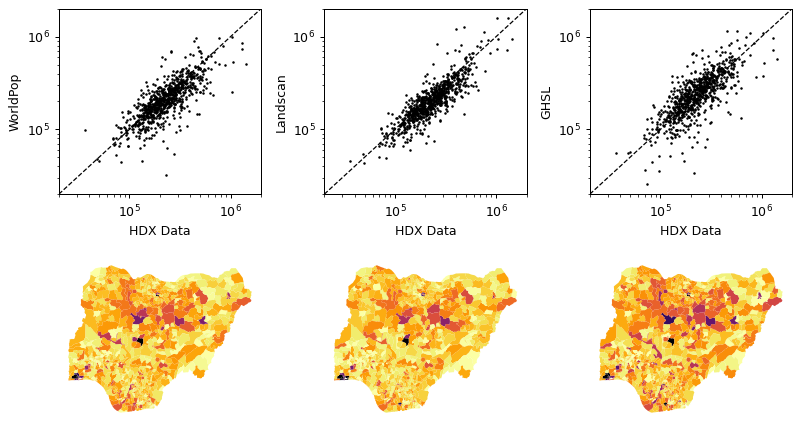

In [15]:
fig,ax = plt.subplots(2, 3, figsize=(9,5), dpi=90)
d = {
    'WorldPop': 'pop_wpgp',
    'Landscan': 'pop_landscan',
    'GHSL': 'pop_ghsl'
    }

for a,b in enumerate(d):
    ax[0,a].plot([2e4, 2e6], [2e4, 2e6], '--k', lw=1)
    ax[0,a].plot(gdf.T_TL, gdf[d[b]], '.k', ms=2)
    ax[0,a].set_xlabel('HDX Data')
    ax[0,a].set_ylabel(b)
    ax[0,a].set_xscale('log')
    ax[0,a].set_yscale('log')
    ax[0,a].set_xlim([2e4, 2e6])
    ax[0,a].set_ylim([2e4, 2e6])
    
    gdf.plot(column=d[b], cmap='inferno_r', vmin=1e5, vmax=1e6, ax=ax[1,a])
    ax[1,a].set_axis_off()
    
plt.tight_layout()
plt.show()

## Computing some statistics
At glance, the scatter plot shows that the gridded population data overestimates the HDX population count. This applies for all three datasets we called. Some statistics or scores can be computed to quantify the difference between the gridded datasets ($x$) and the HDX ($x_0$).
- bias: $\frac{1}{n}\sum(x-x_0)$
- mean absolute percentace error (mape): $\frac{1}{n}\sum{\frac{|x-x_0|}{x_0}}$
- root mean square error (rmse): $\sqrt{\frac{1}{n}\sum{(x-x_0)^2}}$

Departing from the tabular data we have, the scores for each dataset can be computed both in GEE or locally using `gdf` we have.

In [16]:
x0 = ee.Array(agg.aggregate_array('T_TL'));
def compute_score(dataset):
    dev = agg.aggregate_array(dataset)
    bias = dev.reduce('mean')
    mse = (dev.map(lambda x: ee.Number(x).pow(2))
               .reduce('mean'))
    rmse = ee.Number(mse).sqrt()
    mape = (ee.Array(dev).abs().divide(x0).toList()
        .reduce('mean'))
    return ee.Dictionary({'dataset':dataset, 'bias':bias, 'rmse':rmse, 'mape':mape})

stat = ee.List(['dev_wpgp', 'dev_landscan', 'dev_ghsl']).map(compute_score)

stat.getInfo()

[{'bias': -23789.360154415674,
  'dataset': 'dev_wpgp',
  'mape': 0.2257592886991155,
  'rmse': 117528.25878981325},
 {'bias': -27198.43086634706,
  'dataset': 'dev_landscan',
  'mape': 0.2001161769145638,
  'rmse': 103998.44255658734},
 {'bias': 7869.00632713849,
  'dataset': 'dev_ghsl',
  'mape': 0.27855326696701754,
  'rmse': 132843.50551330028}]

In [17]:
stat_local = []
for d in ['wpgp', 'landscan', 'ghsl']:
    a = {
        'dataset': d,
        'bias': gdf[f'dev_{d}'].mean(),
        'rmse': np.sqrt(((gdf[f'dev_{d}'].values)**2).mean()),
        'mape': (np.abs(gdf[f'dev_{d}']/gdf['T_TL']).mean())
        }
    stat_local.append(a)
    
stat_local

[{'dataset': 'wpgp',
  'bias': -23789.360154415674,
  'rmse': 117528.25878981319,
  'mape': 0.2257592886991155},
 {'dataset': 'landscan',
  'bias': -27198.43086634706,
  'rmse': 103998.4425565873,
  'mape': 0.2001161769145638},
 {'dataset': 'ghsl',
  'bias': 7869.00632713849,
  'rmse': 132843.5055133004,
  'mape': 0.27855326696701754}]